In [1]:
from collections import namedtuple

import gym
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.optim import Adam
from torch.distributions import Categorical

In [2]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
env = gym.make("CartPole-v0")
print(env.env.__doc__)


    Description:
        A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum starts upright, and the goal is to prevent it from falling over by increasing and reducing the cart's velocity.

    Source:
        This environment corresponds to the version of the cart-pole problem described by Barto, Sutton, and Anderson

    Observation: 
        Type: Box(4)
        Num	Observation                 Min         Max
        0	Cart Position             -4.8            4.8
        1	Cart Velocity             -Inf            Inf
        2	Pole Angle                 -24 deg        24 deg
        3	Pole Velocity At Tip      -Inf            Inf
        
    Actions:
        Type: Discrete(2)
        Num	Action
        0	Push cart to the left
        1	Push cart to the right
        
        Note: The amount the velocity that is reduced or increased is not fixed; it depends on the angle the pole is pointing. This is because the center of gra

In [4]:
class Policy(nn.Module):
    def __init__(self, state_size, act_size, hidden_size):
        super().__init__()
        self.traj_history = []
        
        self.model = nn.Sequential(
            nn.Linear(state_size, hidden_size, bias=False),
            nn.ReLU(),
            nn.Linear(hidden_size, act_size, bias=False),
            nn.Softmax(dim=0),
        )
        
    def forward(self, state):
        return self.model(state)

In [5]:
def process_traj_batch(policy, discount):
    log_probs = []
    rewards = []
    for idx, transition in enumerate(policy.traj_history):
        rewards.insert(0, sum(discount**i*transition.reward for i in range(idx+1)))
        log_probs.append(transition.prob)
    return log_probs, rewards

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [7]:
moving_average = lambda x, **kw: pd.DataFrame({'x':np.asarray(x)}).x.ewm(**kw).mean().values

In [8]:
transition = namedtuple("transition", ["prob", "reward"])

In [9]:
STATE_SIZE  = env.observation_space.shape[0] # размерность пространства состояний среды
ACT_SIZE = env.action_space.n # размерность пространства действий среды
HIDDEN_SIZE = 256 # размер скрытого слоя для политики
NUM_EPISODES = 1000 # количество эпиздов, которые будут сыграны для обучения
DISCOUNT = 0.99 # фактор дисконтирования

In [10]:
policy = Policy(STATE_SIZE, ACT_SIZE, HIDDEN_SIZE).to(device)
optimizer = Adam(policy.parameters())

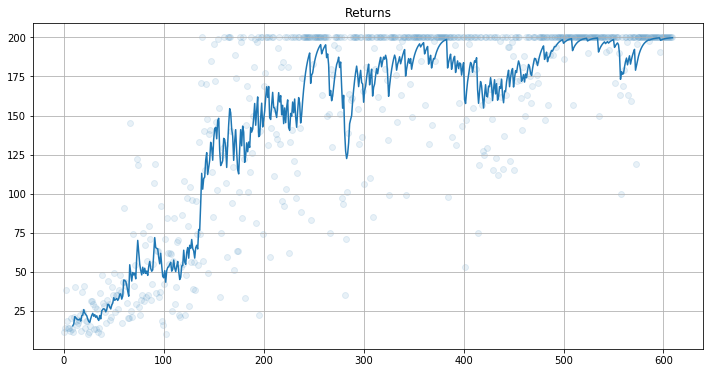

Solved! Running reward is now 195.18 and the last episode runs to 609 time steps!


In [11]:
rewards_history = []
running_reward = 0

for step in range(NUM_EPISODES):
    episode_rewards = 0
    cur_observation = env.reset()
    while True:
        pred = policy(torch.FloatTensor(cur_observation).to(device))
        c = Categorical(pred)
        action = c.sample()
            
        cur_observation, reward, done, _ = env.step(action.data.item())
        episode_rewards += reward
        policy.traj_history.append(transition(prob=c.log_prob(action), reward=reward))
        
        if done:
            break
            
    rewards_history.append(episode_rewards)
    
    log_probs, rewards = process_traj_batch(policy, DISCOUNT)
    loss = -(torch.stack(log_probs) * torch.FloatTensor(rewards).to(device)).sum()
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    policy.traj_history = []
    
    if step % 10:
        clear_output(True)
        plt.figure(figsize=[12, 6])
        plt.title('Returns'); plt.grid()
        plt.scatter(np.arange(len(rewards_history)), rewards_history, alpha=0.1)
        plt.plot(moving_average(rewards_history, span=10, min_periods=10))
        plt.show()
        
    running_reward = np.mean(rewards_history[-100:])
    if running_reward > env.spec.reward_threshold:
        print("Solved! Running reward is now {} and the last episode runs to {} time steps!"\
              .format(running_reward, step))
        break